In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [2]:
BATCH_SIZE = 512
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train = True, download = True,
              transform = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize((0.1037,), (0.3081,))
              ])),
batch_size = BATCH_SIZE, shuffle = True)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('data', train = False, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1037,), (0.3081,))
])),
batch_size = BATCH_SIZE, shuffle = True)

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1*1*28*28
        self.conv1 = nn.Conv2d(1,10,5)
        self.conv2 = nn.Conv2d(10, 20, 3) 
        self.fc1 = nn.Linear(20 * 10 * 10, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        out = self.conv1(x) # 1* 10 * 24 *24
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2) # 1* 10 * 12 * 12
        out = self.conv2(out) # 1* 20 * 10 * 10
        out = F.relu(out)
        out = out.view(in_size, -1) # 1 * 2000
        out = self.fc1(out) # 1 * 500
        out = F.relu(out)
        out = self.fc2(out) # 1 * 10
        out = F.log_softmax(out, dim = 1)
        return out

In [5]:
model = ConvNet().to(DEVICE)
optimizer = optim.Adam(model.parameters())

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
def test(model, device, test_loader):
    model.eval()
    test_loss =0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction = 'sum') # 将一批的损失相加
            pred = output.max(1, keepdim = True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) \n".format(
        test_loss, correct, len(test_loader.dataset),
        100.* correct / len(test_loader.dataset)
            ))

In [8]:
for epoch in range(1, EPOCHS + 1):
    train(model,  DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch: 1 [14848/60000 (25%)]	Loss: 0.318396
Train Epoch: 1 [30208/60000 (50%)]	Loss: 0.174063
Train Epoch: 1 [45568/60000 (75%)]	Loss: 0.159320

Test set: Average loss: 0.0918, Accuracy: 9720/10000 (97%) 

Train Epoch: 2 [14848/60000 (25%)]	Loss: 0.082195
Train Epoch: 2 [30208/60000 (50%)]	Loss: 0.061439
Train Epoch: 2 [45568/60000 (75%)]	Loss: 0.058346

Test set: Average loss: 0.0563, Accuracy: 9824/10000 (98%) 

Train Epoch: 3 [14848/60000 (25%)]	Loss: 0.060588
Train Epoch: 3 [30208/60000 (50%)]	Loss: 0.031316
Train Epoch: 3 [45568/60000 (75%)]	Loss: 0.058930

Test set: Average loss: 0.0512, Accuracy: 9840/10000 (98%) 

Train Epoch: 4 [14848/60000 (25%)]	Loss: 0.028407
Train Epoch: 4 [30208/60000 (50%)]	Loss: 0.053187
Train Epoch: 4 [45568/60000 (75%)]	Loss: 0.028905

Test set: Average loss: 0.0382, Accuracy: 9874/10000 (99%) 

Train Epoch: 5 [14848/60000 (25%)]	Loss: 0.043066
Train Epoch: 5 [30208/60000 (50%)]	Loss: 0.038717
Train Epoch: 5 [45568/60000 (75%)]	Loss: 0.040046

T

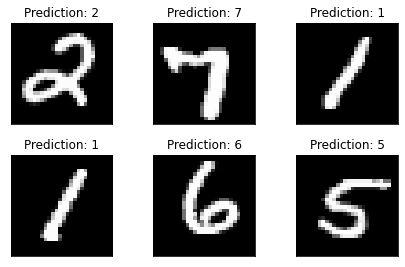

In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = model(example_data)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()